**Problem statement**


For the given data from the amazon reviews, perform the below activities:

1.       Clean the data

2.       Plot a bigram bar graph on the top words 25 words

3.       Find customer concern areas - the top 25 bigrams which includes the below negative words indicating the customer concern areas

             `'poor', 'waste', 'bad', 'defective', 'disgusting', 'untrusty', 'worst', 'horrible', 'unexpectedly', 'slow'`

4.       Plot a bar graph for the top 25 customer concern areas

In [1]:
reset -fs

In [2]:
import datetime as dt
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import itertools
import string
import wordcloud

import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from collections import Counter
from sklearn import svm
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore') # Hides warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
sns.set_style("whitegrid") # Plotting style

# Plots show up in notebook
%matplotlib inline

The dataset, Amazon customer reviews, provided in the `XLSM (Macro-enabled Excel Worksheet)` has been converted to comma-separated values text file without tampering the data

In [3]:
# Importing dataset as a `Pandas` dataframe 
cr_df = pd.read_csv('./data/Amazon_Customer_Reviews.csv')

In [4]:
# Getting the features of the dataset
cr_df.keys()

Index(['id', 'asin', 'helpful', 'overall', 'reviewText', 'reviewTime',
       'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')

In [5]:
# Fetching the top data records of the dataframe
cr_df.head()

,id,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,528881469,"[0, 0]",5,We got this GPS for my husband who is an (OTR)...,"06 2, 2013",AO94DHGC771SJ,amazdnu,Gotta have GPS!,1370131200
1,1,528881469,"[12, 15]",1,"I'm a professional OTR truck driver, and I bou...","11 25, 2010",AMO214LNFCEI4,Amazon Customer,Very Disappointed,1290643200
2,2,528881469,"[43, 45]",3,"Well, what can I say. I've had this unit in m...","09 9, 2010",A3N7T0DY83Y4IG,C. A. Freeman,1st impression,1283990400
3,3,528881469,"[9, 10]",2,"Not going to write a long review, even thought...","11 24, 2010",A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","Great grafics, POOR GPS",1290556800
4,4,528881469,"[0, 0]",1,I've had mine for a year and here's what we go...,"09 29, 2011",A24EV6RXELQZ63,Wayne Smith,"Major issues, only excuses for support",1317254400


In [6]:
# Describe basic information of the dataframe
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              999 non-null    int64 
 1   asin            999 non-null    object
 2   helpful         999 non-null    object
 3   overall         999 non-null    int64 
 4   reviewText      997 non-null    object
 5   reviewTime      999 non-null    object
 6   reviewerID      999 non-null    object
 7   reviewerName    994 non-null    object
 8   summary         999 non-null    object
 9   unixReviewTime  999 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 78.2+ KB


We can observe that there are a few null values for two of the columns (997 for `reviewText`, 994 for `reviewName`)

**Reformat datetime from raw form in `reviewTime`**

In [7]:
cr_df["reviewTime"] = pd.to_datetime(cr_df["reviewTime"])

**Rearrange the left-to-right by relevance**

In [8]:
cr_df = cr_df[['asin', 'summary', 'reviewText', 'overall', 'reviewerID', 'reviewerName', 'helpful', 'reviewTime',
      'unixReviewTime']]

In [9]:
cr_df.head(5)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
0,528881469,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...,5,AO94DHGC771SJ,amazdnu,"[0, 0]",2013-06-02,1370131200
1,528881469,Very Disappointed,"I'm a professional OTR truck driver, and I bou...",1,AMO214LNFCEI4,Amazon Customer,"[12, 15]",2010-11-25,1290643200
2,528881469,1st impression,"Well, what can I say. I've had this unit in m...",3,A3N7T0DY83Y4IG,C. A. Freeman,"[43, 45]",2010-09-09,1283990400
3,528881469,"Great grafics, POOR GPS","Not going to write a long review, even thought...",2,A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","[9, 10]",2010-11-24,1290556800
4,528881469,"Major issues, only excuses for support",I've had mine for a year and here's what we go...,1,A24EV6RXELQZ63,Wayne Smith,"[0, 0]",2011-09-29,1317254400


In [10]:
cr_df.tail(5)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime
994,9983891212,Excellent,A cable runs lifetime. Excellent product that ...,5,A11QNB7FPVY3V,VESTALIA TORRES,"[0, 0]",2014-02-21,1392940800
995,9983891212,"This mini HDMI cable, well, it works",Quality of connection and video seems good wit...,5,AMGIMGPA34FIZ,Victor Kirkpatrick,"[1, 1]",2011-04-29,1304035200
996,9983891212,Good cable,What is there to say? I needed a cable to run...,5,A22XH75Z0895RC,weave,"[0, 0]",2013-06-26,1372204800
997,9983891212,Premium Canon Mini HDMI cable (10 ft),I can find nothing wrong with this cable. It ...,5,A2XVGWQZN26LX9,William J. Weisensee,"[0, 0]",2013-11-16,1384560000
998,9983891212,Perfect for Canon EOS 7d,Works perfectly at 1080p HD and in all other C...,5,A2UFAKH7Y8VH5N,WilliWu,"[12, 12]",2010-04-07,1270598400


**Number of Reviews by Unique Products `asin`**

In [11]:
reviews = cr_df['overall'].groupby(cr_df['asin']).count()
print("Number of unique reviews : {}".format(reviews.count()))

Number of unique reviews : 40


**Top 25 Reviewed Products**

In [12]:
sorted_reviews = reviews.sort_values(ascending=False)

print("Top 20 Reviewed Products:\n")
print(sorted_reviews[:20], end='\n\n')
print('Most reviewed products, - has {} reviews.'.format(reviews.max()))

Top 20 Reviewed Products:

asin
972683275     219
1400532655    109
9983891212     82
140053271X     71
1400501466     43
1400532620     41
1400599997     41
9625993428     35
9573212919     34
1400698987     28
9575871979     25
1400501776     20
1400501520     20
3744295508     19
9888002198     18
9983891204     17
1400532736     13
7214047977     13
9966694544     13
1400699169     12
Name: overall, dtype: int64

Most reviewed products, - has 219 reviews.


**Grabbing the review texts of the products**

In [13]:
cr_df['reviewText'][:11]

0     We got this GPS for my husband who is an (OTR)...
1     I'm a professional OTR truck driver, and I bou...
2     Well, what can I say.  I've had this unit in m...
3     Not going to write a long review, even thought...
4     I've had mine for a year and here's what we go...
5     I am using this with a Nook HD+. It works as d...
6     The cable is very wobbly and sometimes disconn...
7     This adaptor is real easy to setup and use rig...
8     This adapter easily connects my Nook HD 7&#34;...
9     This product really works great but I found th...
10    This item is just as was described in the orig...
Name: reviewText, dtype: object

In [14]:
reviews_txt = cr_df['reviewText']
reviews_txt.head(5)

0    We got this GPS for my husband who is an (OTR)...
1    I'm a professional OTR truck driver, and I bou...
2    Well, what can I say.  I've had this unit in m...
3    Not going to write a long review, even thought...
4    I've had mine for a year and here's what we go...
Name: reviewText, dtype: object

**Process tokenise and lemmatize the reviews**

In [15]:
stops = stopwords.words('english')

In [16]:
def lemmatize(tokens):
    lmtzr = WordNetLemmatizer()
    lemma = [lmtzr.lemmatize(t) for t in tokens]
    return lemma

In [17]:
def tokenize(text):
    tokenized = word_tokenize(text)
    no_punc = []
    for review in tokenized:
        line = "".join(char for char in review if char not in string.punctuation)
        no_punc.append(line)
    tokens = lemmatize(no_punc)
    return tokens

In [18]:
reviews_txt = reviews_txt.apply(lambda x: tokenize(str(x)))

In [19]:
reviews_txt[:11]

0     [We, got, this, GPS, for, my, husband, who, is...
1     [I, m, a, professional, OTR, truck, driver, , ...
2     [Well, , what, can, I, say, , I, ve, had, this...
3     [Not, going, to, write, a, long, review, , eve...
4     [I, ve, had, mine, for, a, year, and, here, s,...
5     [I, am, using, this, with, a, Nook, HD, , It, ...
6     [The, cable, is, very, wobbly, and, sometimes,...
7     [This, adaptor, is, real, easy, to, setup, and...
8     [This, adapter, easily, connects, my, Nook, HD...
9     [This, product, really, work, great, but, I, f...
10    [This, item, is, just, a, wa, described, in, t...
Name: reviewText, dtype: object

**Classification / Sentiment Analysis**

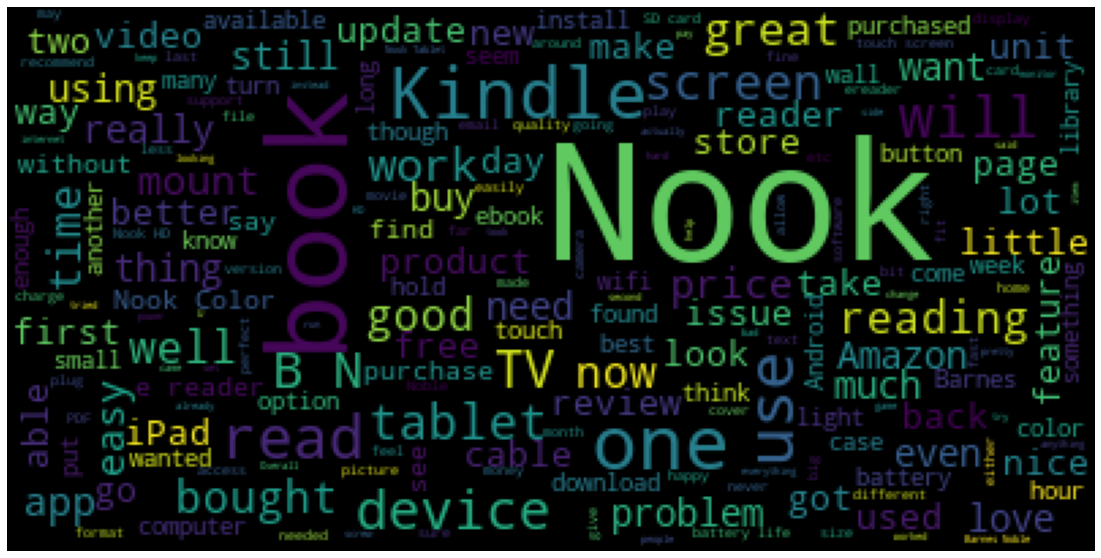

In [20]:
cloud = wordcloud.WordCloud(background_color='black', max_font_size=60, relative_scaling=1).generate(" ".join([str(x) for x in cr_df['reviewText']]))
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(cloud)

**Categorize Reviews into Positive**

```
Negative reviews:      1-3 Stars  = 0
Positive reviews:      4-5 Stars  = 1
```

In [21]:
cr_df['reviewFeedback'] = [1 if x > 3 else 0 for x in cr_df['overall']]

In [22]:
cr_df.head(5)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,reviewFeedback
0,528881469,Gotta have GPS!,We got this GPS for my husband who is an (OTR)...,5,AO94DHGC771SJ,amazdnu,"[0, 0]",2013-06-02,1370131200,1
1,528881469,Very Disappointed,"I'm a professional OTR truck driver, and I bou...",1,AMO214LNFCEI4,Amazon Customer,"[12, 15]",2010-11-25,1290643200,0
2,528881469,1st impression,"Well, what can I say. I've had this unit in m...",3,A3N7T0DY83Y4IG,C. A. Freeman,"[43, 45]",2010-09-09,1283990400,0
3,528881469,"Great grafics, POOR GPS","Not going to write a long review, even thought...",2,A1H8PY3QHMQQA0,"Dave M. Shaw ""mack dave""","[9, 10]",2010-11-24,1290556800,0
4,528881469,"Major issues, only excuses for support",I've had mine for a year and here's what we go...,1,A24EV6RXELQZ63,Wayne Smith,"[0, 0]",2011-09-29,1317254400,0


In [23]:
cr_df.tail(5)

,asin,summary,reviewText,overall,reviewerID,reviewerName,helpful,reviewTime,unixReviewTime,reviewFeedback
994,9983891212,Excellent,A cable runs lifetime. Excellent product that ...,5,A11QNB7FPVY3V,VESTALIA TORRES,"[0, 0]",2014-02-21,1392940800,1
995,9983891212,"This mini HDMI cable, well, it works",Quality of connection and video seems good wit...,5,AMGIMGPA34FIZ,Victor Kirkpatrick,"[1, 1]",2011-04-29,1304035200,1
996,9983891212,Good cable,What is there to say? I needed a cable to run...,5,A22XH75Z0895RC,weave,"[0, 0]",2013-06-26,1372204800,1
997,9983891212,Premium Canon Mini HDMI cable (10 ft),I can find nothing wrong with this cable. It ...,5,A2XVGWQZN26LX9,William J. Weisensee,"[0, 0]",2013-11-16,1384560000,1
998,9983891212,Perfect for Canon EOS 7d,Works perfectly at 1080p HD and in all other C...,5,A2UFAKH7Y8VH5N,WilliWu,"[12, 12]",2010-04-07,1270598400,1


**Test/Train Split**

In [24]:
x_train, x_test, y_train, y_test = train_test_split(cr_df.reviewText, cr_df.reviewFeedback, random_state=0)

print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (749,)
y_train shape: (749,)

x_test shape: (250,)
y_test shape: (250,)



Text(0.5, 1.0, 'Distribution of Reviews Category')

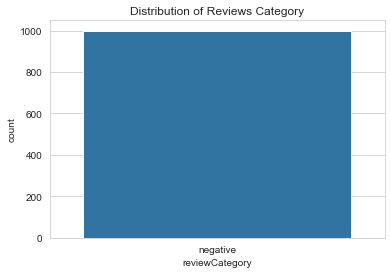

In [30]:
def feedback_category(score):
    if score < 3:
        return "negative"
    elif score > 3:
        return "positive"
    else:
        return "neutral"

cr_df['reviewCategory'] = cr_df['reviewFeedback'].apply(lambda x: feedback_category(x))

cr_df.sample(5)
cr_df['reviewText'] = cr_df['reviewText'].apply(lambda x: str(x))
    
sns.countplot(cr_df['reviewCategory']).set_title("Distribution of Reviews Category")

In [31]:
from collections import Counter
def get_most_common(reviews_list, topn=20):
    reviews = " ".join(reviews_list)
    tokenised_reviews = reviews.split(" ")
    freq_counter = Counter(tokenised_reviews)
    return freq_counter.most_common(topn) # return words with the highest frequencies

In [32]:
positive_reviews = cr_df.loc[cr_df['reviewFeedback'] == 1,'reviewText'].tolist() # extracting all positive reviews and converting to a list
positive_reviews[0:5]

negative_reviews = cr_df.loc[cr_df['reviewFeedback'] == 0,'reviewText'].tolist() # extracting all negative reviews and converting to a list
negative_reviews[0:5]

positive_reviews_top25 = get_most_common(positive_reviews, 25)
negative_reviews_top25 = get_most_common(negative_reviews, 25)

**Plot world clouds**

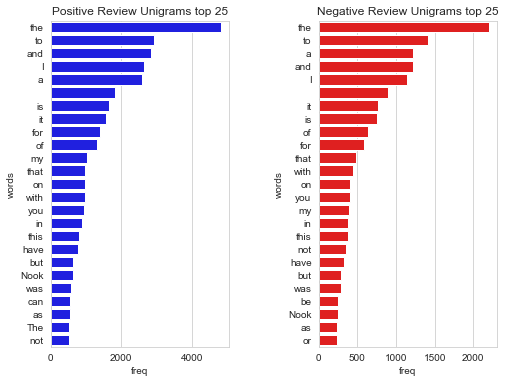

In [35]:
def plot_most_common_words(reviews_list,topn=20,title="Common Review Words",color="blue",axis=None): #default number of words is given as 20
    top_words = get_most_common(reviews_list, topn=topn)
    data = pd.DataFrame()
    data['words'] = [val[0] for val in top_words]
    data['freq'] = [val[1] for val in top_words]
    if axis != None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title + " top " + str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title + " top " + str(topn))


from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6 # Sets the heigth and width of image
fig,ax = plt.subplots(1,2)
fig.subplots_adjust(wspace=0.5) # Adjusts the space between the two plots
plot_most_common_words(positive_reviews,25,"Positive Review Unigrams",axis=ax[0])
plot_most_common_words(negative_reviews,25,"Negative Review Unigrams",color="red",axis=ax[1])